In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sbhatti/financial-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 68.0MB/s]


In [6]:
!unzip /content/financial-sentiment-analysis.zip

Archive:  /content/financial-sentiment-analysis.zip
  inflating: data.csv                


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Bidirectional,Embedding,GlobalAveragePooling1D,Flatten,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split


In [8]:
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
df=pd.read_csv(r'/content/data.csv')

In [9]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [46]:
df.shape

(5842, 2)

In [10]:
df.isnull().sum().sum()

0

In [11]:
df.duplicated().sum()

6

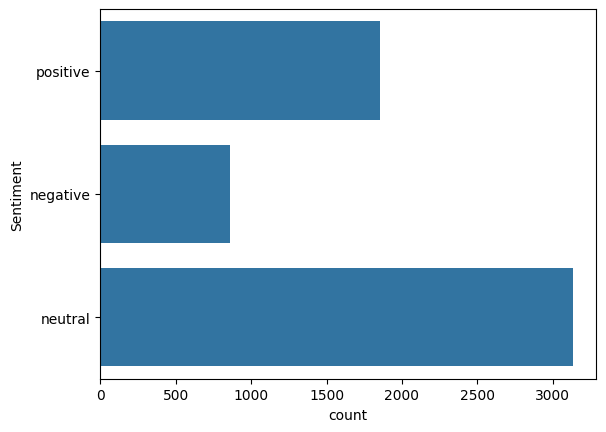

In [15]:
sns.countplot(df['Sentiment'])
plt.show()

In [11]:
# upsampling the data
positive_df = df[(df['Sentiment']=='positive')]
negative_df = df[(df['Sentiment']=='negative')]
neutral_df = df[(df['Sentiment']=='neutral')]

entries_list = [negative_df, neutral_df, positive_df]
resampled_entries_list = []

num_of_samples = 3000

for sentiment in entries_list:
    resampled_entries = resample(sentiment, replace=True, n_samples=num_of_samples, random_state=42)
    resampled_entries_list.append(resampled_entries)

df= pd.concat(resampled_entries_list)

# Plot of sentiments distribution


In [103]:
df['Sentiment'].value_counts()

Sentiment
negative    3000
neutral     3000
positive    3000
Name: count, dtype: int64

In [21]:
text="he GeoSolutions technology will leverage"
simple_preprocess(text)

['he', 'geosolutions', 'technology', 'will', 'leverage']

text preprocessing

In [114]:
def text_lower(text):
  return text.lower()

def remove_special_characters(text):
  return re.sub(r'[a-zA-Z0-9\s]','',text)

def remove_stopwords(text):
  _stopwords = set(stopwords.words('english'))
  words = text.split()
  _words = [word for word in words if word.lower() not in _stopwords]
  return ' '.join(_words)

In [115]:
df['Sentence']=df['Sentence'].apply(text_lower)
df['Sentence']=df['Sentence'].apply(remove_special_characters)
df['Sentence']=df['Sentence'].apply(remove_stopwords)

In [12]:
le=LabelEncoder()
df['Sentiment']=le.fit_transform(df['Sentiment'])

In [26]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


tokenization

In [13]:
num_words=10000
tokenizer = Tokenizer(num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(df['Sentence'])
sequences = tokenizer.texts_to_sequences(df['Sentence'])

In [14]:
word_index=tokenizer.word_index

In [16]:
len(word_index)

9650

In [119]:
sequence_length = [len(sequence) for sequence in sequences]
max_length=max(sequence_length)


In [17]:
max_length=25

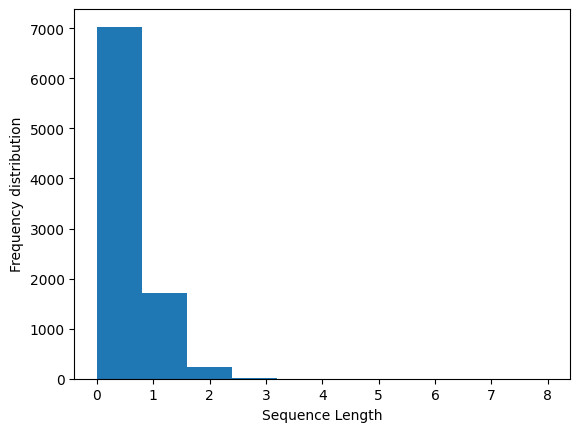

In [126]:
plt.hist(sequence_length, bins=10)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency distribution')
plt.show()

In [22]:
# padding
padded_sequences = pad_sequences(sequences, maxlen=25,padding='post')


In [24]:
padded_sequences

array([[   2,  747,  662, ...,    0,    0,    0],
       [3798,   54,  833, ...,    0,    0,    0],
       [ 201,    2,  182, ...,    0,    0,    0],
       ...,
       [   2,  144, 3234, ...,    0,    0,    0],
       [  23,   58,  777, ...,    7,   25,  320],
       [ 737,  339,   59, ...,    0,    0,    0]], dtype=int32)

In [19]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Sentiment'], test_size=0.2, random_state=42,shuffle=True)


In [25]:
X_train.shape,y_train.shape

((7200, 25), (7200,))

In [123]:
model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=256),
    GlobalAveragePooling1D(),
    Dropout(0.02),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Flatten(),
    Dense(3, activation='softmax')
])


In [28]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [29]:
epochs = 20
batch_size = 128


In [27]:
model = Sequential()
model.add(Embedding(input_dim = num_words,
                          output_dim = 100,
                          input_length= X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,return_sequences=False)))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [30]:
# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
57/57 [==============================] - 103s 2s/step - loss: 0.9880 - accuracy: 0.4825 - val_loss: 0.7620 - val_accuracy: 0.6900
Epoch 2/20
57/57 [==============================] - 75s 1s/step - loss: 0.6122 - accuracy: 0.7568 - val_loss: 0.5667 - val_accuracy: 0.7822
Epoch 3/20
57/57 [==============================] - 71s 1s/step - loss: 0.3698 - accuracy: 0.8704 - val_loss: 0.4684 - val_accuracy: 0.8439
Epoch 4/20
57/57 [==============================] - 75s 1s/step - loss: 0.2666 - accuracy: 0.9053 - val_loss: 0.4589 - val_accuracy: 0.8533
Epoch 5/20
57/57 [==============================] - 86s 2s/step - loss: 0.1990 - accuracy: 0.9265 - val_loss: 0.4190 - val_accuracy: 0.8706
Epoch 6/20
57/57 [==============================] - 78s 1s/step - loss: 0.1780 - accuracy: 0.9311 - val_loss: 0.4715 - val_accuracy: 0.8733
Epoch 7/20
57/57 [==============================] - 103s 2s/step - loss: 0.1641 - accuracy: 0.9337 - val_loss: 0.4712 - val_accuracy: 0.8739
Epoch 8/20
57/57 [

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
model_checkpoint = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
model.fit(X_train,y_train, epochs = 15, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [early_stopping, model_checkpoint])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           1000000   
                                                                 
 dropout (Dropout)           (None, 25, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 25, 256)           234496    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 25, 512)           1050624   
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 25, 512)           0

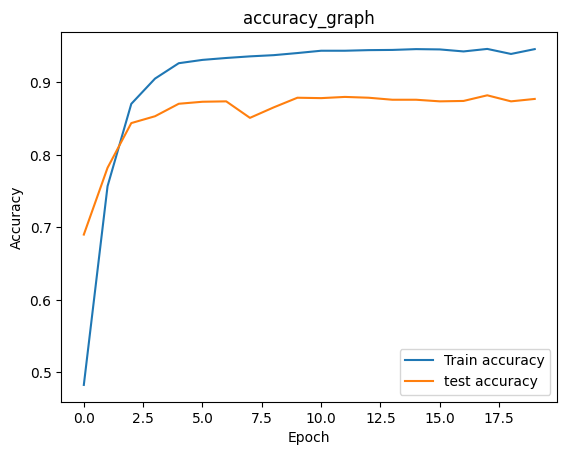

In [35]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("accuracy_graph")
plt.show()

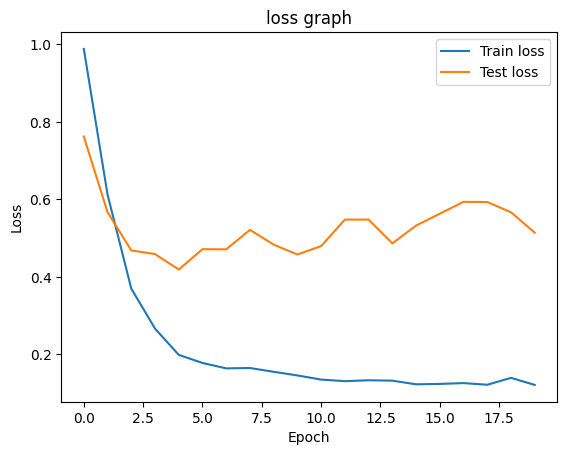

In [36]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("loss graph")
plt.show()